In [2]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from prophet import Prophet
import numpy as np

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

display(data)

,date,open,high,low,close,adjclose,volume,ticker
0,2022-02-09,176.050003,176.649994,174.899994,176.279999,174.052216,71285000,AAPL
1,2022-02-10,174.139999,175.479996,171.550003,172.119995,169.944763,90865900,AAPL
2,2022-02-11,172.330002,173.080002,168.039993,168.639999,166.508759,98670700,AAPL
3,2022-02-14,167.369995,169.580002,166.559998,168.880005,166.745758,86185500,AAPL
4,2022-02-15,170.970001,172.949997,170.250000,172.789993,170.606323,62527400,AAPL
...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL


In [3]:
print(data.columns)

Index(['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')


In [24]:
# Simple Moving Average (SMA)
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)

# Create lagged closing prices
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

display(data)

,date,open,high,low,close,adjclose,volume,ticker,SMA_10,RSI_14,20_SMA,20_std,Upper_Band,Lower_Band,Close_1,Close_2
19,2022-03-09,161.479996,163.410004,159.410004,162.949997,160.890640,91454900,AAPL,163.156000,37.179469,166.169501,4.873161,175.915822,156.423179,157.440002,159.300003
20,2022-03-10,160.199997,160.389999,155.979996,158.520004,156.516647,105342000,AAPL,162.734000,36.439778,165.281501,4.540624,174.362748,156.200254,162.949997,157.440002
21,2022-03-11,158.929993,159.279999,154.500000,154.729996,152.774536,96970100,AAPL,161.721999,34.446900,164.412001,4.818695,174.049391,154.774611,158.520004,162.949997
22,2022-03-14,151.449997,154.119995,150.100006,150.619995,148.716476,108732100,AAPL,160.271999,33.509847,163.511001,5.606782,174.724565,152.297437,154.729996,158.520004
23,2022-03-15,150.899994,155.570007,150.380005,155.089996,153.130005,92964300,AAPL,159.460999,44.037340,162.821500,5.757663,174.336826,151.306175,150.619995,154.729996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL,190.703998,49.883308,188.155998,4.309938,196.775873,179.536123,186.860001,184.399994
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL,190.082997,56.857413,188.480998,3.989362,196.459721,180.502275,185.850006,186.860001
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL,189.494998,60.960283,188.667999,3.932484,196.532967,180.803030,187.679993,185.850006
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912399,53439000,AAPL,188.985999,51.600984,188.881499,3.845821,196.573140,181.189857,189.300003,187.679993


In [25]:
# Prepare the DataFrame for Prophet
data_prophet = data[['date', 'close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']].copy()
data_prophet.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

# Normalize the additional regressors
data_prophet['SMA_10'] = (data_prophet['SMA_10'] - data_prophet['SMA_10'].mean()) / data_prophet['SMA_10'].std()
data_prophet['RSI_14'] = (data_prophet['RSI_14'] - data_prophet['RSI_14'].mean()) / data_prophet['RSI_14'].std()
data_prophet['Upper_Band'] = (data_prophet['Upper_Band'] - data_prophet['Upper_Band'].mean()) / data_prophet['Upper_Band'].std()
data_prophet['Lower_Band'] = (data_prophet['Lower_Band'] - data_prophet['Lower_Band'].mean()) / data_prophet['Lower_Band'].std()
data_prophet['Close_1'] = (data_prophet['Close_1'] - data_prophet['Close_1'].mean()) / data_prophet['Close_1'].std()
data_prophet['Close_2'] = (data_prophet['Close_2'] - data_prophet['Close_2'].mean()) / data_prophet['Close_2'].std()


In [26]:
# Split the dataset into 80% training and 20% testing
train_size = int(len(data_prophet) * 0.8)
train = data_prophet[:train_size]
test = data_prophet[train_size:]
display(train.shape)
display(test.shape)

(386, 8)

(97, 8)

In [27]:
# Initialize the Prophet model
model = Prophet()

# Add the additional regressors
model.add_regressor('SMA_10')
model.add_regressor('RSI_14')
model.add_regressor('Upper_Band')
model.add_regressor('Lower_Band')
model.add_regressor('Close_1')
model.add_regressor('Close_2')

# Fit the model on training data
model.fit(train)

14:49:13 - cmdstanpy - INFO - Chain [1] start processing
14:49:13 - cmdstanpy - INFO - Chain [1] done processing


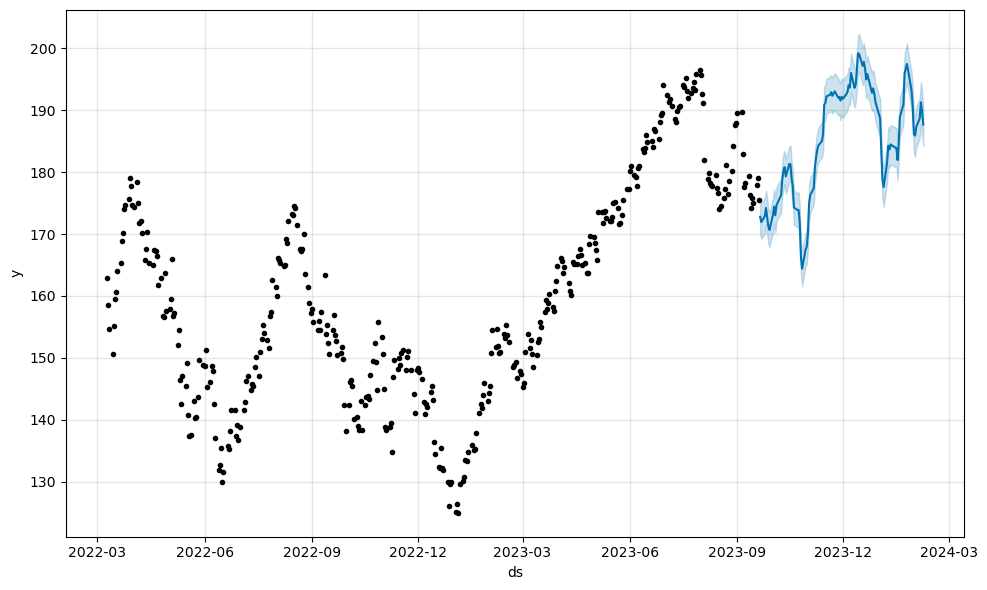

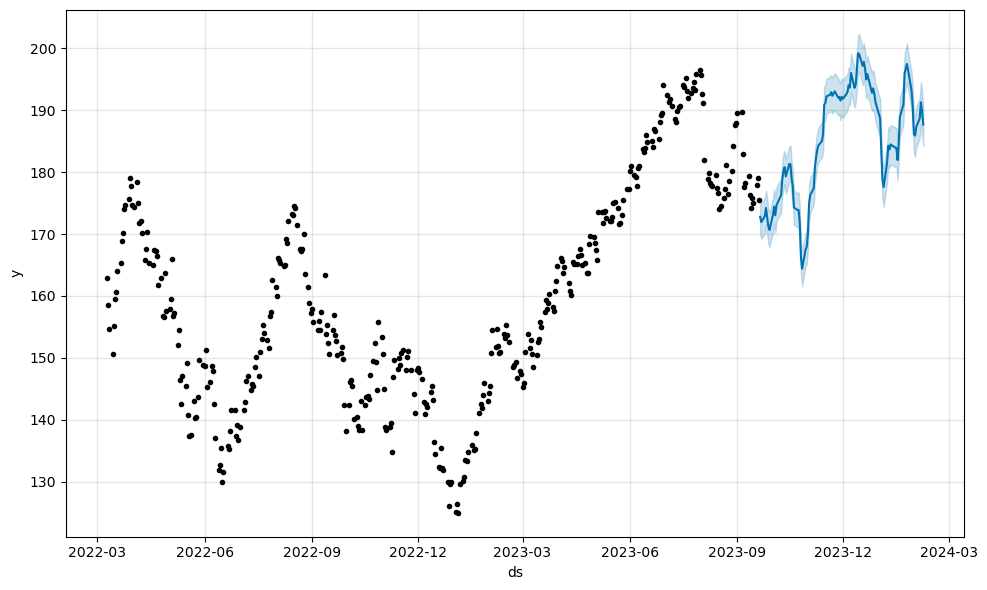

In [28]:
# Make future dataframe for the testing period
future = test[['ds']].copy()

# Add the same indicators to the future DataFrame
future['SMA_10'] = test['SMA_10']
future['RSI_14'] = test['RSI_14']
future['Upper_Band'] = test['Upper_Band']
future['Lower_Band'] = test['Lower_Band']
future['Close_1'] = test['Close_1']
future['Close_2'] = test['Close_2']

# Make predictions
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE
y_true = test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 1.6561235684510764
Root Mean Squared Error: 1.986199334960813
